In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Tuple, Dict

import torch

from train_model import Pixels, MEAN, STD, ModeModel

In [62]:
def torch_to_numpy(tensor):
    """To numpy"""
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    elif isinstance(tensor, dict):
        return {key: torch_to_numpy(value) for key, value in tensor.items()}
    elif isinstance(tensor, (list, tuple)):
        return [torch_to_numpy(item) for item in tensor]
    else:
        raise TypeError("Unsupported type encountered: {}".format(type(tensor)))
    
def real_to_complex(y: np.ndarray) -> np.ndarray:
    """
    Convert a 1D float array containing real and imaginary parts to an array of complex numbers.

    Args:
        y: A 1D numpy array where the real parts are at even indices (0, 2, 4, ...)
           and the imaginary parts are at odd indices (1, 3, 5, ...).

    Returns:
        A numpy array of complex numbers reconstructed from the real and imaginary parts.

    Example:
        >>> import numpy as np
        >>> real_parts = np.array([1., 3., 5.])
        >>> imag_parts = np.array([2., -4., 6.])
        >>> real_to_complex(np.concatenate([real_parts, imag_parts]))
        array([1. + 2.j, 3. - 4.j, 5. + 6.j])
    """

    if isinstance(y, torch.Tensor):
        y = torch_to_numpy(y)

    if len(y) % 2 != 0:
        raise ValueError("Input array must have an even number of elements.")

    n = len(y) // 2
    real_parts = y[:n]
    imag_parts = y[n:]
    complex_arr = np.array(real_parts + 1j * imag_parts)
    return complex_arr

def get_modes(
    mode_files_folder: str,
) -> Tuple[Dict[str, np.ndarray], np.ndarray, np.ndarray]:
    """Load mode files and coordinates from the specified folder.

    Args
    ----
    mode_files_folder: Path to the folder containing mode files.

    Returns
    -------
    A tuple containing:
        - modes_dict: A dictionary mapping mode filenames to their corresponding data arrays.
        - y_coords: Y coordinates in micrometers.
        - z_coords: Z coordinates in micrometers.
    """
    modes_dict = {}

    for projection in ("x", "y", "z"):
        for v in range(1, 16):
            filename = f"E{v}_{projection}"
            mode_txt = f"/{filename}.txt"
            full_filename = mode_files_folder + mode_txt
            E = np.loadtxt(full_filename, delimiter=",", dtype=np.complex128)
            modes_dict[filename] = E.T
    y_coords = np.loadtxt(f"{mode_files_folder}/y.txt", delimiter=",", dtype=float)
    z_coords = np.loadtxt(f"{mode_files_folder}/z.txt", delimiter=",", dtype=float)

    return (
        modes_dict,
        y_coords * 1e6,
        z_coords * 1e6,
    )  # modes_dict, y_coords [micron], z_coords [micron]
    
def xy_plot(x: np.ndarray, ax=None):
    """x = [44*8]"""

    x = x.reshape(8, 44).T  # exacly that order

    linestyles = dict(
        lw=3,
        ls="dashed",
    )

    plate_length = 33e3
    plate_width = 6e3
    pixel_length = 750
    pixel_width = pixel_length

    replace_dict = {1: "#fdb279", 0: "#d3426d"}

    # строим график
    if ax is None:
        ax = plt.gca()

    ax.set_facecolor("black")

    for i in range(44):
        for j in range(8):
            ax.add_patch(
                patches.Rectangle(
                    (
                        pixel_length * (i) - plate_length / 2,
                        pixel_width * (j) - plate_width / 2,
                    ),
                    pixel_length,
                    pixel_width,
                    angle=0.0,
                    color=replace_dict[x[i, j]],
                    # alpha=0.1
                )
            )

    ax.plot(
        [-plate_length / 2, plate_length / 2],
        [-plate_width / 2, -plate_width / 2],
        "w",
        alpha=1,
        **linestyles,
    )
    ax.plot(
        [-plate_length / 2, plate_length / 2],
        [+plate_width / 2, +plate_width / 2],
        "w",
        alpha=1,
        **linestyles,
    )
    ax.plot(
        [-plate_length / 2, -plate_length / 2],
        [-plate_width / 2, +plate_width / 2],
        "w",
        alpha=1,
        **linestyles,
    )
    ax.plot(
        [plate_length / 2, plate_length / 2],
        [-plate_width / 2, +plate_width / 2],
        "w",
        alpha=1,
        **linestyles,
    )

    return ax

def recreate_E(
    alphas: np.ndarray, betas: np.ndarray, modes_dict: Dict[str, np.ndarray]
):
    """
    Reconstructs an electromagnetic field (E-field) by linearly combining mode profiles
    with given coefficients.
    src: https://optics.ansys.com/hc/en-us/articles/360034902433-Using-and-understanding-Mode-Expansion-Monitors

    Parameters:
        - alphas (np.complex128): Coefficients for the linear combination of mode profiles.
        Should be a list or 1D NumPy array of length 15, corresponding to mode coefficients.
        - modes_dict: A dictionary containing mode profiles, typically obtained from
        the 'get_modes' function.

    Returns:
        A NumPy array representing the reconstructed E-field.

    The 'recreate_E' function takes coefficients 'alphas' and combines them with mode profiles
    stored in 'modes_dict' to recreate the E-field. The resulting E-field is computed as
    the absolute value of the linear combination of mode profiles weighted by 'alphas'.

    Example usage:
        >>> alphas = [0.1, 0.2, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        >>> modes_dict, _, _ = get_modes("folder_path", projection="z")
        >>> reconstructed_E = recreate_E(alphas, modes_dict)
    """
    size = list(modes_dict.values())[0].shape
    E_recreation = np.zeros(size, dtype=np.complex128)
    Ex = np.zeros(size, dtype=np.complex128)
    Ey = np.zeros(size, dtype=np.complex128)
    Ez = np.zeros(size, dtype=np.complex128)

    for i in range(1, 16):
        filename = f"E{i}_x"
        Ex_tmp = modes_dict[filename]
        Ex += (
            alphas[i - 1] - betas[i - 1]
        ) * Ex_tmp  # "-" because wave progate along x axis

        filename = f"E{i}_y"
        Ey_tmp = modes_dict[filename]
        Ey += (alphas[i - 1] + betas[i - 1]) * Ey_tmp

        filename = f"E{i}_z"
        Ez_tmp = modes_dict[filename]
        Ez += (alphas[i - 1] + betas[i - 1]) * Ez_tmp

    E_recreation = np.sqrt(np.abs(Ex) ** 2 + np.abs(Ey) ** 2 + np.abs(Ez) ** 2)
    return E_recreation

def yz_plot(ax, y_coords, z_coords, E):
    """y_coords, z_coords - micron"""
    linestyles = dict(
        lw=3,
        ls="dashed",
    )

    pixel_height = 23 * 1e-3
    plate_width = 6e3 * 1e-3
    plate_height = 220 * 1e-3

    ax.set_xlabel("y, $\\mu$m")
    ax.set_ylabel("z, $\\mu$m")

    ax.plot([-plate_width / 2, plate_width / 2], [0, 0], "w", alpha=1, **linestyles)
    ax.plot(
        [-plate_width / 2, plate_width / 2],
        [+(pixel_height + plate_height), +(pixel_height + plate_height)],
        "w",
        alpha=1,
        **linestyles,
    )
    ax.plot(
        [-plate_width / 2, -plate_width / 2],
        [0, (pixel_height + plate_height)],
        "w",
        alpha=1,
        **linestyles,
    )
    ax.plot(
        [plate_width / 2, plate_width / 2],
        [0, (pixel_height + plate_height)],
        "w",
        alpha=1,
        **linestyles,
    )

    # plt.colorbar()

    return ax.pcolormesh(y_coords, z_coords, E, cmap="magma")

In [63]:
experiment_dir = "./experiment"
path_to_data = "./input/sweep"

In [64]:
test_dataset = Pixels(
    root=path_to_data,
    annfile="test",
    is_scaler=True,
    mean=MEAN,
    std=STD,
)

model = ModeModel()
model.load_state_dict(
    torch.load(os.path.join(experiment_dir, "model.pth"), map_location="cpu")
)
model.eval()

ModeModel(
  (mode_model): GeneralModel(
    (model): Sequential(
      (0): Linear(in_features=352, out_features=500, bias=True)
      (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): GELU(approximate='none')
      (4): Linear(in_features=500, out_features=500, bias=True)
      (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.1, inplace=False)
      (7): GELU(approximate='none')
      (8): Linear(in_features=500, out_features=500, bias=True)
      (9): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Dropout(p=0.1, inplace=False)
      (11): GELU(approximate='none')
      (12): Linear(in_features=500, out_features=500, bias=True)
      (13): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Dropout(p=0.1, inplace=False)
      (15): GELU(approximate='non

In [65]:
path_to_modes = "/home-local/ibragimov/AIIP/aiip/input/modes"
modes_dict, y_coords, z_coords = get_modes(path_to_modes)

modes_dict.keys()

dict_keys(['E1_x', 'E2_x', 'E3_x', 'E4_x', 'E5_x', 'E6_x', 'E7_x', 'E8_x', 'E9_x', 'E10_x', 'E11_x', 'E12_x', 'E13_x', 'E14_x', 'E15_x', 'E1_y', 'E2_y', 'E3_y', 'E4_y', 'E5_y', 'E6_y', 'E7_y', 'E8_y', 'E9_y', 'E10_y', 'E11_y', 'E12_y', 'E13_y', 'E14_y', 'E15_y', 'E1_z', 'E2_z', 'E3_z', 'E4_z', 'E5_z', 'E6_z', 'E7_z', 'E8_z', 'E9_z', 'E10_z', 'E11_z', 'E12_z', 'E13_z', 'E14_z', 'E15_z'])

length = 374
n = 133
seed = 3643


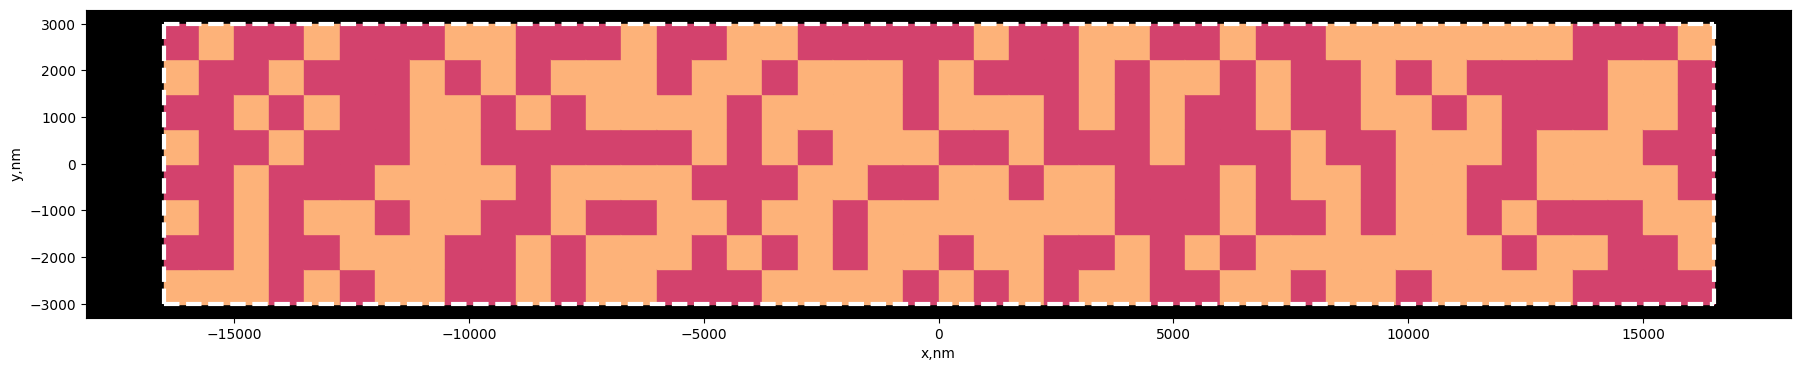

In [66]:
length = len(test_dataset)
print(f"{length = }")
n = np.random.randint(length)
print(f"{n = }")
x, y, seed = test_dataset[n]
print(f"{seed = }")
fig, ax = plt.subplots(1, 1, figsize=(22, 4))
cls = xy_plot(torch_to_numpy(x), ax)
plt.xlabel('x,nm')
plt.ylabel('y,nm')
# plt.savefig("pixels_true.svg", bbox_inches="tight", transparent=True)
plt.show()

In [67]:
inverse_y_true = test_dataset.standard_scaler.inverse_transform(y[None, :])[0]
alphas_true = real_to_complex(inverse_y_true)

1.0815244857806259
E_recreated.shape = (33, 166)


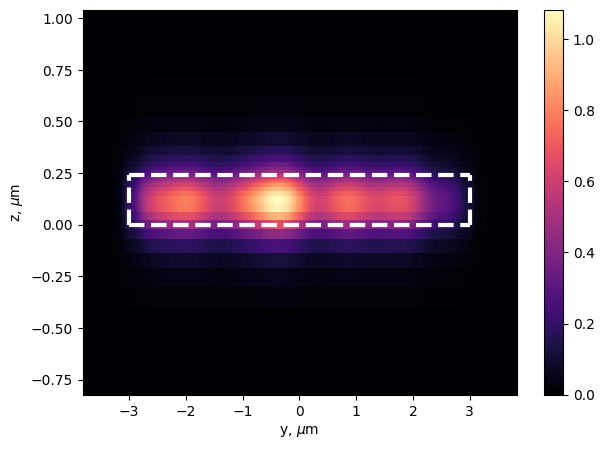

In [68]:
E_recreated = recreate_E(alphas_true, alphas_true*0, modes_dict)

print(f"{E_recreated.max()}")
print(f"{E_recreated.shape = }")
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
cls = yz_plot(ax, y_coords, z_coords, E_recreated)
fig.colorbar(cls)
# plt.savefig("E_true.svg", bbox_inches="tight", transparent=True)
plt.show()

y_pred.shape = torch.Size([30])
0.9766711036571952
E_recreated.shape = (33, 166)


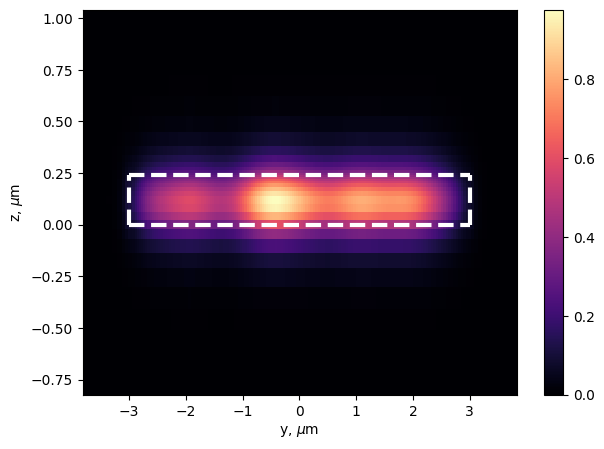

In [69]:
model_model = model.mode_model

y_pred = model_model(x[None, :])[0]
inverse_y_pred = test_dataset.standard_scaler.inverse_transform(torch_to_numpy(y_pred[None, :]))[0]
alphas_pred = real_to_complex(inverse_y_pred)

print(f"{y_pred.shape = }")

E_recreated = recreate_E(alphas_pred, alphas_pred*0, modes_dict)

print(f"{E_recreated.max()}")
print(f"{E_recreated.shape = }")
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
cls = yz_plot(ax, y_coords, z_coords, E_recreated)
fig.colorbar(cls)
# plt.savefig("E_predicted (mode_model).svg", bbox_inches="tight", transparent=True)
plt.show()

In [70]:
alphas_pred

array([-8.8941318e-01-0.02810888j,  6.1361864e-02+0.16151723j,
        1.3208422e-01-0.03813589j, -4.5713574e-02+0.10345286j,
       -1.2123630e-01+0.04120402j, -9.0961158e-02+0.04934496j,
       -6.0869404e-03-0.01464444j, -3.3162449e-02-0.04894436j,
        2.1170773e-02+0.00070157j, -1.1114117e-02+0.01381661j,
       -1.1052998e-02+0.02383783j, -1.2333880e-02-0.01055715j,
       -8.8072969e-03-0.01555032j,  9.7676500e-05-0.00856623j,
       -3.2471013e-03+0.00367048j], dtype=complex64)

In [71]:
alphas_true

array([-0.909336  +0.0230774j , -0.0987787 -0.149007j  ,
        0.130083  -0.0988008j ,  0.0451857 -0.0386658j ,
       -0.11484   +0.0755904j , -0.150683  +0.0115657j ,
       -0.0170755 -0.0119091j , -0.0202378 +0.0850096j ,
        0.041727  +0.00659949j, -0.0586394 -0.0219799j ,
       -0.0211848 +0.0225394j ,  0.0130096 -0.0132651j ,
       -0.026146  -0.0144287j , -0.0106679 -0.0045604j ,
       -0.00655307+0.0066831j ])

In [72]:
mse_loss = torch.nn.MSELoss(reduction="mean") 
mse_loss(y_pred[None, :], y[None, ])

tensor(0.6673, grad_fn=<MseLossBackward0>)